In [2]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# import keras_metrics as km
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import math

In [4]:
data_dir = "/content/drive/MyDrive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
classes = ["fall", "fall_down", "grab", "swallow", "walk","sit"]

In [7]:
def frames_extraction(video_path):
    frames_list = []
     
    vidcap = cv2.VideoCapture(video_path)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

    frames_step = total_frames//seq_len
 
    for j in range(seq_len):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,j*frames_step)
        success,image = vidcap.read()  
        #save your image
        if success:
          image = cv2.resize(image, (img_height, img_width))
          frames_list.append(image)
        else:
          print("Defected frame {}".format(video_path))
          break

    return frames_list

In [8]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [9]:
X, Y = create_data(data_dir)
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

walk
fall_down
swallow
Defected frame /content/drive/MyDrive/video_data/swallow/70.mov
fall
grab
sit


In [10]:
model = Sequential()
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True, padding = 'same', data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), strides = (2,2), return_sequences = True, padding = 'same', data_format = "channels_last"))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = True, padding = 'same', data_format = "channels_last"))
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), strides = (2,2), return_sequences = False, padding = 'same', data_format = "channels_last"))
model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(6, activation = "softmax"))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 16, 64, 64, 32)    40448     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 16, 32, 32, 32)    73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 32, 32, 32)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 16, 32, 32, 64)    221440    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 16, 16, 64)        295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0

In [11]:
def schedular(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * math.exp(0.1*(10-epoch))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
31/31 [==============================] - 971s 30s/step - loss: 2.3755 - accuracy: 0.2616 - val_loss: 1.7570 - val_accuracy: 0.2927
Epoch 2/20
31/31 [==============================] - 926s 30s/step - loss: 1.6800 - accuracy: 0.4439 - val_loss: 1.7115 - val_accuracy: 0.4634
Epoch 3/20
31/31 [==============================] - 913s 29s/step - loss: 1.3170 - accuracy: 0.5118 - val_loss: 1.7039 - val_accuracy: 0.3577
Epoch 4/20
31/31 [==============================] - 933s 30s/step - loss: 1.3044 - accuracy: 0.5006 - val_loss: 1.6660 - val_accuracy: 0.3902
Epoch 5/20
31/31 [==============================] - 921s 30s/step - loss: 1.2741 - accuracy: 0.5136 - val_loss: 1.6493 - val_accuracy: 0.3659
Epoch 6/20
31/31 [==============================] - 948s 31s/step - loss: 1.1771 - accuracy: 0.5339 - val_loss: 1.6198 - val_accuracy: 0.4309
Epoch 7/20
31/31 [==============================] - 966s 31s/step - loss: 0.9599 - accuracy: 0.6425 - val_loss: 1.6135 - val_accuracy: 0.3171
Epoch 

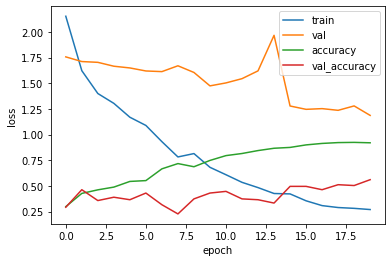

In [12]:
opt = optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)
 
history = model.fit(x = X_train, y = y_train, epochs=20, batch_size = 16, shuffle=True, validation_split=0.2, callbacks=[callbacks])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))


              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.62      0.45      0.52        53
           2       0.48      0.63      0.55        19
           3       1.00      0.90      0.95        10
           4       0.56      0.70      0.62        43
           5       0.70      0.74      0.72        19

    accuracy                           0.60       154
   macro avg       0.63      0.62      0.62       154
weighted avg       0.61      0.60      0.59       154

accuracy score : 0.5974025974025974
